In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

from scipy import stats

from causalgraphicalmodels import CausalGraphicalModel

import warnings

print('Running on pymc3 version {}'.format(pm.__version__))


warnings.filterwarnings('ignore')
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Running on pymc3 version 3.11.2


## Ex. 1

Construct a linear regression of weight as predicted by height, using the adults (age 18 or greater) from the Howell1 dataset. The heights listed below were recorded in the !Kung census, but weights were not recorded for these individuals. Provide predicted weights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

Heights: 140, 160, 175

In [27]:
#read and filter df
df = pd.read_csv('data/Howell1.csv', sep=';')
df1 = df[df.age >= 18]
df1['height_s'] = df1.height - np.mean(df1.height)

In [28]:
df1.head()

,height,weight,age,male,height_s
0,151.765,47.825606,63.0,1,-2.832093
1,139.700,36.485807,63.0,0,-14.897093
2,136.525,31.864838,65.0,0,-18.072093
3,156.845,53.041914,41.0,1,2.247907
4,145.415,41.276872,51.0,0,-9.182093


In [29]:
df1.weight.mean()

44.99048551988636

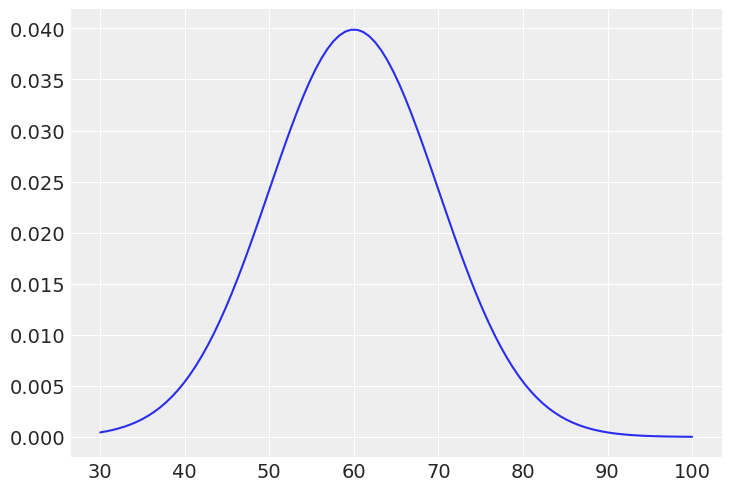

In [30]:
#select priors alpha: weight when height is at average
x = np.linspace(30, 100, 100)
y = stats.norm.pdf(x, 60, 10)
plt.plot(x, y)

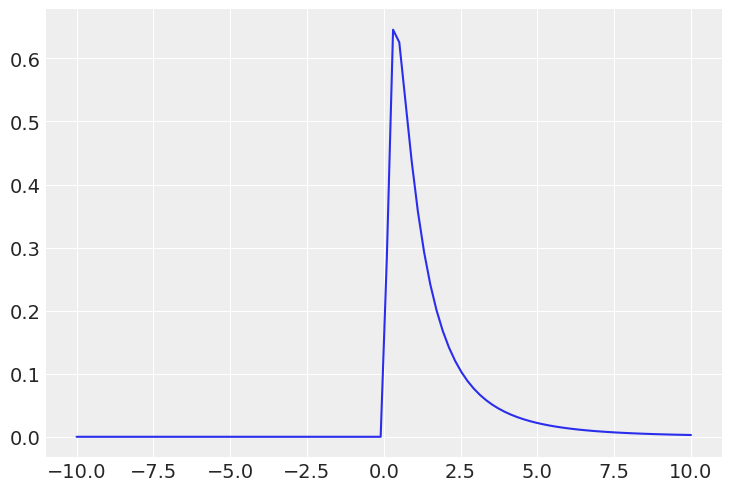

In [31]:
#priors beta
x = np.linspace(-10, 10, 100)
y = stats.lognorm.pdf(x, 1)
plt.plot(x, y)

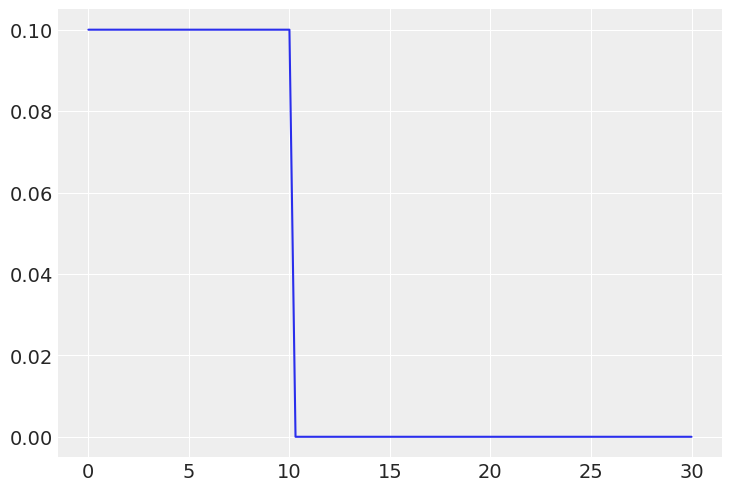

In [32]:
#prior sigma
x = np.linspace(0, 30, 100)
y = stats.uniform.pdf(x, 0, 10)
plt.plot(x, y)

Model definition 

\begin{split}\begin{aligned}
W_i  &\sim Normal(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_H H_i \\
\alpha &\sim Normal(60, 10) \\
\beta_H &\sim LogNormal(0, 1) \\
\sigma &\sim Uniform(0, 10)
\end{aligned}\end{split}



In [33]:
with pm.Model() as w_2_1:
    
    #define input data
    height_s = pm.Data("height_s", df1['height_s'])
    weight = pm.Data("weight", df1['weight'])

    #define priors
    alpha = pm.Normal("alpha", mu=60, sd=10)
    beta_h = pm.Lognormal("beta_h", sd=1)
    sigma = pm.Uniform("sigma", 0, 10)

    #define regression
    mu = pm.Deterministic("mu", alpha + beta_h*height_s)
    
    weight_hat = pm.Normal("weight_hat", mu=mu, sd=sigma, observed=weight)
    
    #prior sampling
    prior = pm.sample_prior_predictive()

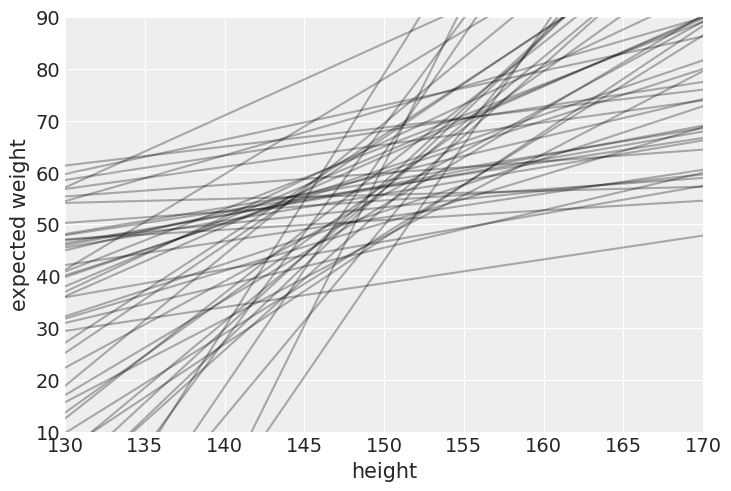

In [34]:
#simulate from priors

x = np.linspace(130, 170, 30)
x_bar = 150

fig, ax = plt.subplots()
ax.set_xlim(130, 170)
ax.set_ylim(10,90)
ax.set_xlabel('height')
ax.set_ylabel('expected weight')

for a, b in zip(prior['alpha'][:50], prior['beta_h'][:50]):
    y = a + b*(x-x_bar)
    plt.plot(x, y, color='black', alpha=0.3)  

In [35]:
with w_2_1:
    trace_2_1 = pm.sample(1000, tune=1000,return_inferencedata=False)
    posterior_2_1 = pm.sample_posterior_predictive(trace=trace_2_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_h, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [36]:
var_names = ['alpha', 'beta_h', 'sigma']

with w_2_1:
    summary = az.summary(trace_2_1, var_names=var_names)
summary    

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,45.001,0.223,44.599,45.434,0.003,0.002,5102.0,2895.0,1.0
beta_h,0.629,0.030,0.576,0.686,0.000,0.000,5352.0,2822.0,1.0
sigma,4.256,0.161,3.954,4.551,0.002,0.002,5741.0,2905.0,1.0


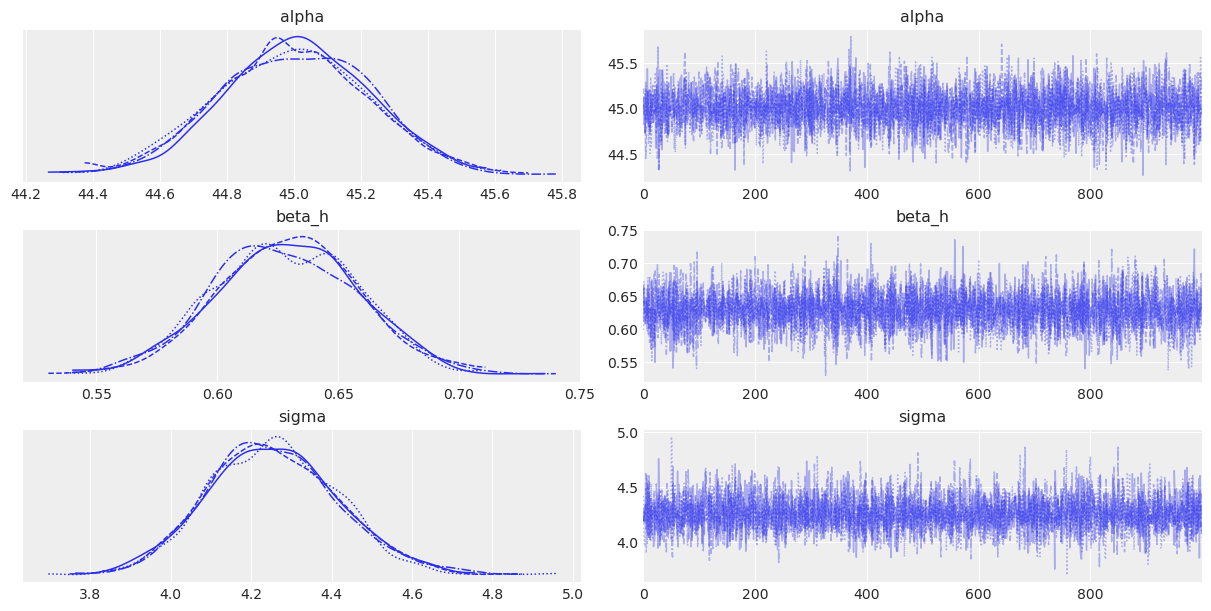

In [37]:
with w_2_1:
    az.plot_trace(trace_2_1, var_names=var_names)

In [38]:
#validate with simulation

np.random.seed(seed=233423)

alpha = 70
beta = 0.5
sigma = 5
n_individuals = 100

H = stats.uniform.rvs(loc=130, scale=60, size=n_individuals)
mu = alpha + beta*(H-H.mean())
W = stats.norm.rvs(loc=mu,scale=5, size=n_individuals)

H_s = H - H.mean()

In [39]:
with pm.Model() as w_2_2:
    
    #define input data
    height_s = pm.Data("height_s", H_s)
    weight = pm.Data("weight", W)

    #define priors
    alpha = pm.Normal("alpha", mu=60, sd=10)
    beta_h = pm.Lognormal("beta_h", sd=1)
    sigma = pm.Uniform("sigma", 0, 10)

    #define regression
    mu = pm.Deterministic("mu", alpha + beta_h*height_s)
    
    weight_hat = pm.Normal("weight_hat", mu=mu, sd=sigma, observed=weight)
    
    #prior sampling
    prior = pm.sample_prior_predictive()
    trace_2_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_h, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [40]:
var_names = ['alpha', 'beta_h', 'sigma']

with w_2_2:
    summary = az.summary(trace_2_2, var_names=var_names)
summary    

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,70.226,0.491,69.313,71.123,0.007,0.005,5059.0,2722.0,1.0
beta_h,0.506,0.027,0.458,0.559,0.000,0.000,4970.0,2816.0,1.0
sigma,4.801,0.350,4.131,5.447,0.005,0.004,4762.0,2715.0,1.0


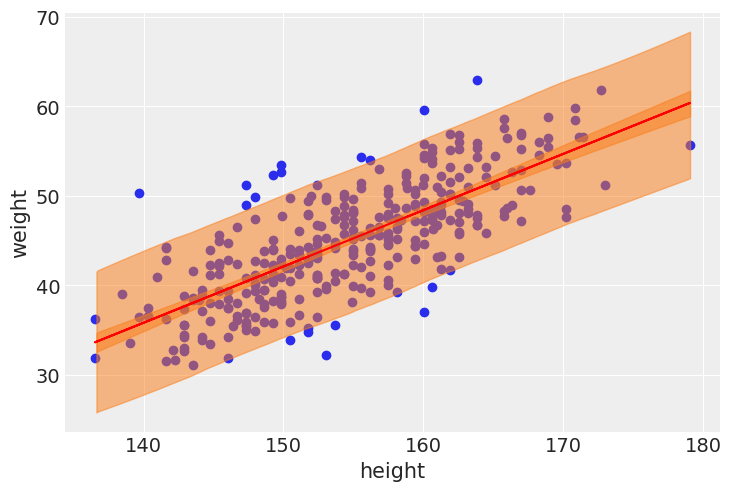

In [41]:
#plot sample
#plot posterior mean
#plot uncertainity of the mean
#plot uncertainity of the predictions

mu_mean = trace_2_1['mu'].mean(axis=0)

fig, ax = plt.subplots()
ax.set_xlabel('height')
ax.set_ylabel('weight')
    
ax.scatter(df1.height, df1.weight) 
ax.plot(df1.height, mu_mean, color = 'r')
az.plot_hdi(df1.height, trace_2_1['mu'])
az.plot_hdi(df1.height, posterior_2_1['weight_hat']);

In [42]:
#predict for new data
individual = [x for x in range(1, 4)]
height = [140, 160, 175]
expected_weight = np.nan
hdi_low = np.nan
hdi_high = np.nan

In [43]:
df_pred = pd.DataFrame({'individual':individual,
                        'height':height,
                        'expected_weight':expected_weight,
                        'hdi_low':hdi_low,
                        'hdi_high':hdi_high})
df_pred

,individual,height,expected_weight,hdi_low,hdi_high
0,1,140,NaN,NaN,NaN
1,2,160,NaN,NaN,NaN
2,3,175,NaN,NaN,NaN


In [44]:
df_pred['height_s'] = df_pred['height'] - df1['height'].mean()

In [45]:
with w_2_1:
    pm.set_data({
    "height_s": df_pred['height_s']
    })
    
    height_pred_data = pm.sample_posterior_predictive(trace_2_1)


In [46]:
df_pred['expected_weight'] = height_pred_data['weight_hat'].mean(axis=0)
df_pred[['hdi_low', 'hdi_high']] = az.hdi(height_pred_data['weight_hat'])

In [50]:
df_pred

,individual,height,expected_weight,hdi_low,hdi_high,height_s
0,1,140,35.725121,27.822511,43.978760,-14.597093
1,2,160,48.438060,40.667098,56.597495,5.402907
2,3,175,57.859110,50.048857,66.403924,20.402907


## Ex. 2

From the Howell1 dataset,consider only the people younger than 13 years old. Estimate the causal association between age and weight. Assume that age influences weight through two paths. First, age influences height, and height influences weight. Second, age directly influences weight through age- related changes in muscle growth and body proportions.

Use a linear regression to estimate the total (not just direct) causal effect of each year of growth on weight. Be sure to carefully consider the priors. Try using prior predictive simulation to assess what they imply.

In [51]:
df2 = df[df.age <13]

In [52]:
df2.shape

(146, 4)

In [53]:
df2.head()

,height,weight,age,male
18,121.92,19.617854,12.0,1
19,105.41,13.947954,8.0,0
20,86.36,10.489315,6.5,0
24,109.22,15.989118,7.0,0
30,114.30,17.860185,11.0,1


In [54]:
df2['age_s'] = df2['age'] - df2['age'].mean()

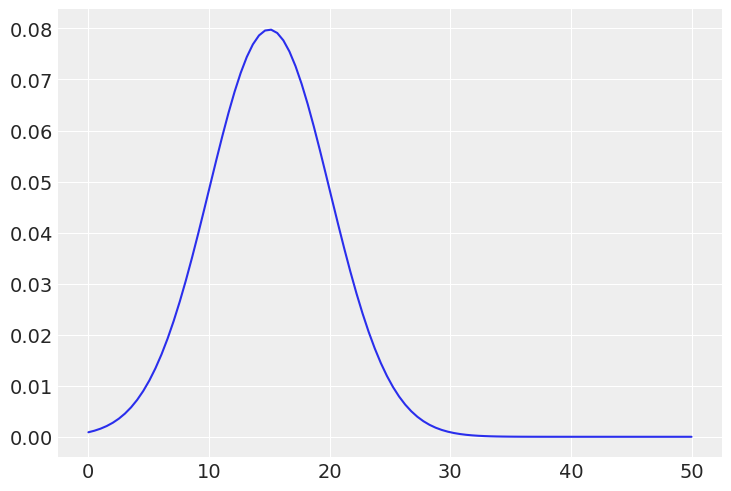

In [ ]:
#select priors alpha: weight when age is at average
x = np.linspace(0, 50, 100)
y = stats.norm.pdf(x, 15, 5)
plt.plot(x, y)

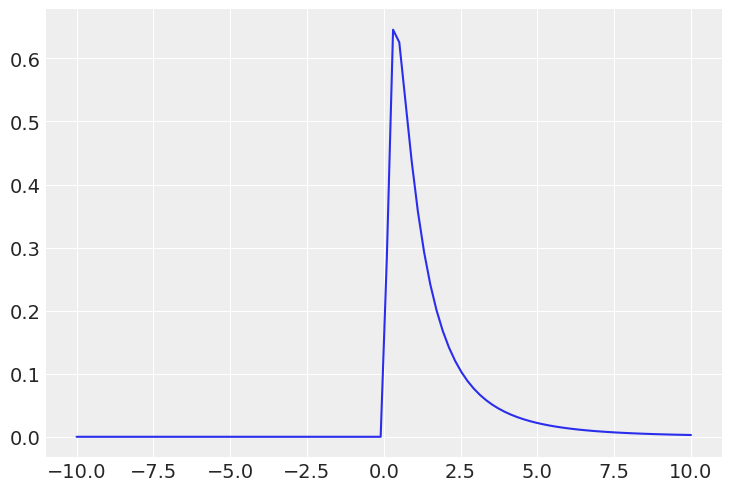

In [ ]:
#priors beta
x = np.linspace(-10, 10, 100)
y = stats.lognorm.pdf(x, 1)
plt.plot(x, y)

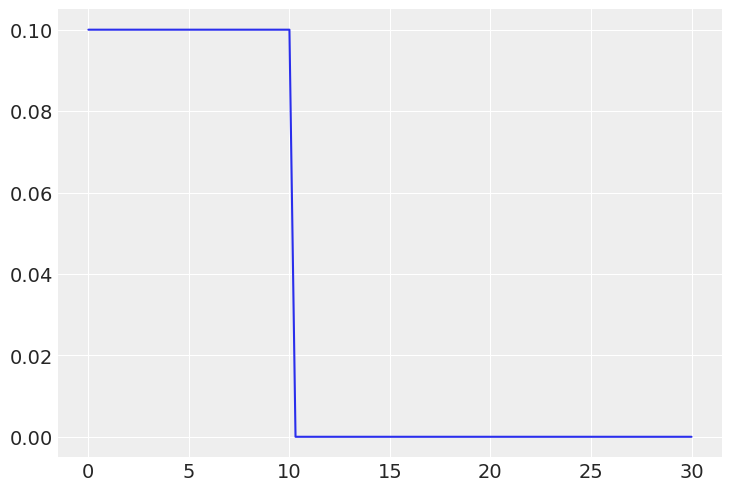

In [ ]:
#prior sigma
x = np.linspace(0, 30, 100)
y = stats.uniform.pdf(x, 0, 10)
plt.plot(x, y)

Model definition 

\begin{split}\begin{aligned}
W_i  &\sim Normal(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_A A_i \\
\alpha &\sim Normal(20, 10) \\
\beta_A &\sim LogNormal(0, 1) \\
\sigma &\sim Uniform(0, 10)
\end{aligned}\end{split}



In [ ]:
with pm.Model() as w_2_3:
    
    #define input data
    age_s = pm.Data("age_s", df2['age_s'])
    weight = pm.Data("weight", df2['weight'])

    #define priors
    alpha = pm.Normal("alpha", mu=20, sd=10)
    beta_a = pm.Lognormal("beta_a", sd=0.5)
    sigma = pm.Uniform("sigma", 0, 10)

    #define regression
    mu = pm.Deterministic("mu", alpha + beta_a*age_s)
    
    weight_hat = pm.Normal("weight_hat", mu=mu, sd=sigma, observed=weight)
    
    #prior sampling
    prior_2_3 = pm.sample_prior_predictive()

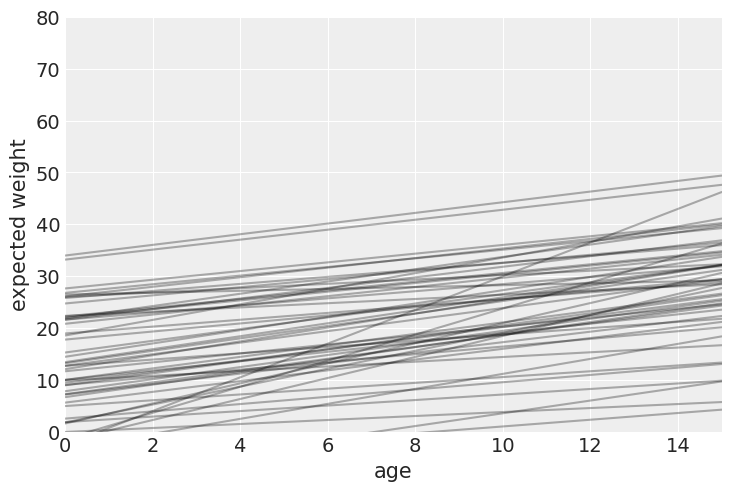

In [ ]:
#simulate from priors

x = np.linspace(0, 15, 30)
x_bar = 7

fig, ax = plt.subplots()
ax.set_xlim(0, 15)
ax.set_ylim(0,80)
ax.set_xlabel('age')
ax.set_ylabel('expected weight')

for a, b in zip(prior_2_3['alpha'][:50], prior_2_3['beta_a'][:50]):
    y = a + b*(x-x_bar)
    plt.plot(x, y, color='black', alpha=0.3)  

In [ ]:
with w_2_3:
    trace_2_3 = pm.sample(1000, tune=1000,return_inferencedata=False)
    posterior_2_3 = pm.sample_posterior_predictive(trace=trace_2_3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_a, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [ ]:
var_names = ['alpha', 'beta_a', 'sigma']

with w_2_3:
    summary = az.summary(trace_2_3, var_names=var_names)
summary   

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,14.702,0.216,14.292,15.094,0.003,0.002,5080.0,2968.0,1.0
beta_a,1.336,0.057,1.236,1.443,0.001,0.001,5575.0,2897.0,1.0
sigma,2.566,0.161,2.288,2.883,0.002,0.002,5818.0,2785.0,1.0


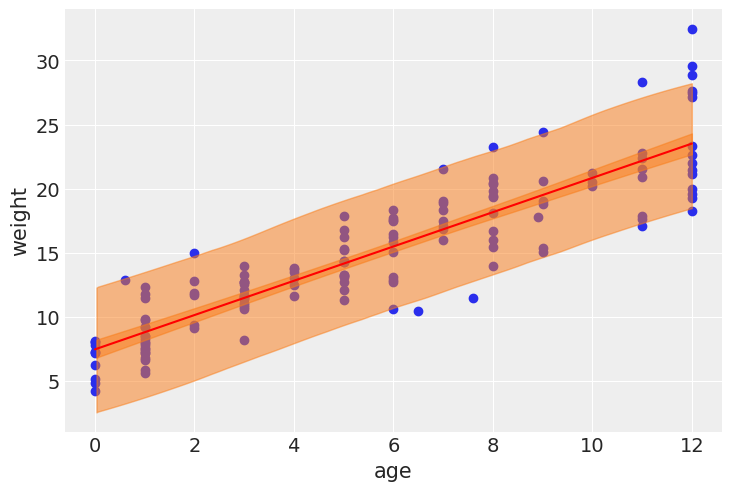

In [ ]:
#plot sample
#plot posterior mean
#plot uncertainity of the mean
#plot uncertainity of the predictions

mu_mean = trace_2_3['mu'].mean(axis=0)

fig, ax = plt.subplots()
ax.set_xlabel('age')
ax.set_ylabel('weight')
    
ax.scatter(df2.age, df2.weight) 
ax.plot(df2.age, mu_mean, color = 'r')
az.plot_hdi(df2.age, trace_2_3['mu'])
az.plot_hdi(df2.age, posterior_2_3['weight_hat']);

## Ex. 3

Now suppose the causal association between age and weight might be different for boys and girls. Use a single linear regression, with a categorical variable for sex, to estimate the total causal effect of age on weight separately for boys and girls. How do girls and boys differ? Provide one or more pos- terior contrasts as a summary.

In [55]:
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [56]:
sex_id = pd.factorize(df2.male)[0]
sex_idx = pd.factorize(df2.male)[1]

In [57]:
#sex and age on weight
with pm.Model() as w_2_5:
    
    #define input data
    age_s = pm.Data("age_s", df2['age_s'])
    weight = pm.Data("weight", df2['weight'])
    sex = pm.Data("sex", sex_id)

    #define priors
    alpha = pm.Normal("alpha", mu=20, sd=10, shape=len(sex_idx))
    beta_a = pm.Lognormal("beta_a", sd=0.5, shape=len(sex_idx))
    sigma = pm.Uniform("sigma", 0, 10)

    #define regression
    mu = pm.Deterministic("mu", alpha[sex] + beta_a[sex]*age_s)
    
    weight_hat = pm.Normal("weight_hat", mu=mu, sd=sigma, observed=weight)
    
    #prior sampling
    prior_2_5 = pm.sample_prior_predictive()

In [58]:
with w_2_5:
    trace_2_5 = pm.sample(1000, tune=1000,return_inferencedata=False)
    posterior_2_5 = pm.sample_posterior_predictive(trace=trace_2_4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_a, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


NameError: name 'trace_2_4' is not defined

In [ ]:
#check summary
var_names = ['alpha', 'beta_a', 'sigma']

with w_2_5:
    summary = az.summary(trace_2_5, var_names=var_names)
summary  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],15.387,0.292,14.870,15.939,0.004,0.003,6095.0,3323.0,1.0
alpha[1],14.029,0.285,13.514,14.570,0.004,0.003,5944.0,3385.0,1.0
beta_a[0],1.379,0.079,1.229,1.523,0.001,0.001,6044.0,3064.0,1.0
beta_a[1],1.281,0.075,1.134,1.417,0.001,0.001,6944.0,2648.0,1.0
sigma,2.479,0.151,2.208,2.775,0.002,0.001,6140.0,3079.0,1.0


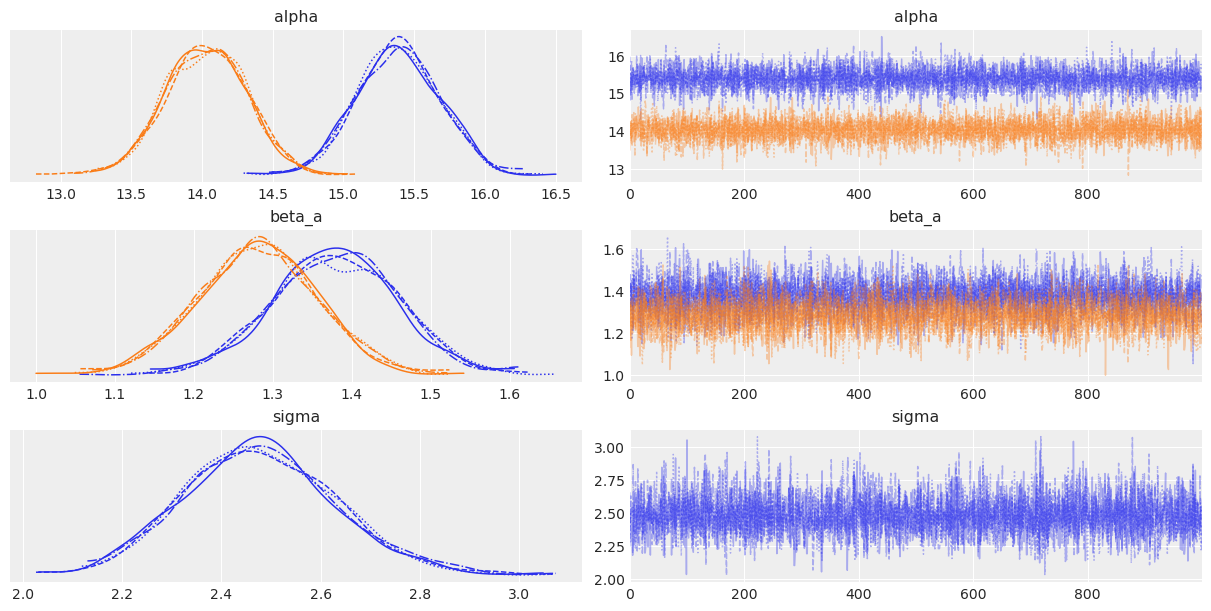

In [ ]:
with w_2_5:
    az.plot_trace(trace_2_5, var_names=var_names)

In [ ]:
#compute posterior contrast
diff = trace_2_5['alpha'][:,0] - trace_2_5['alpha'][:,1]

<AxesSubplot:xlabel='weight at mean age'>

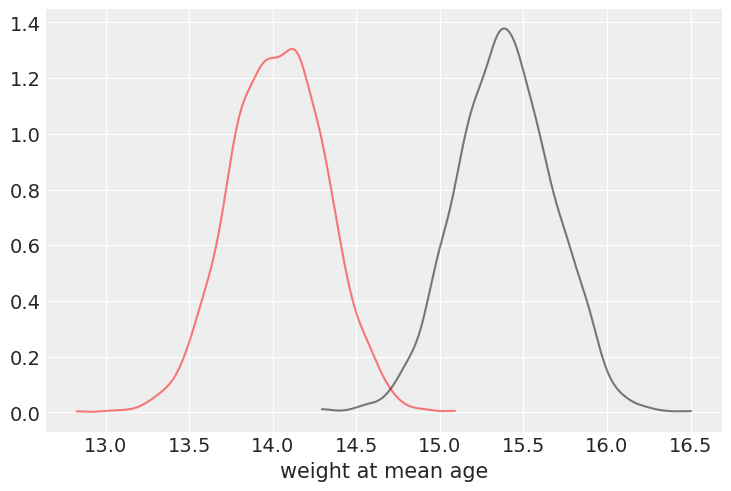

In [ ]:
fix, ax = plt.subplots()

ax.set_xlabel('weight at mean age')
az.plot_kde(trace_2_5['alpha'][:,0], ax=ax, plot_kwargs={"color":"black", "alpha":.5})
az.plot_kde(trace_2_5['alpha'][:,1], ax=ax, plot_kwargs={"color":"red", "alpha":.5})

<AxesSubplot:title={'center':'Kde contrast'}>

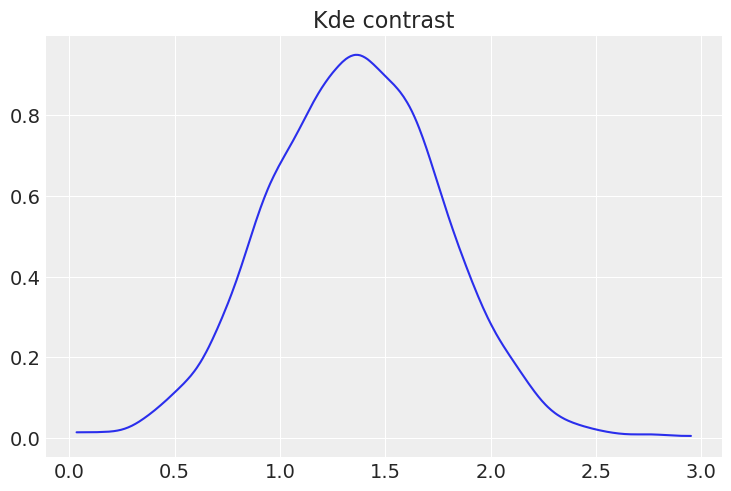

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Kde contrast')
az.plot_kde(diff, ax=ax)

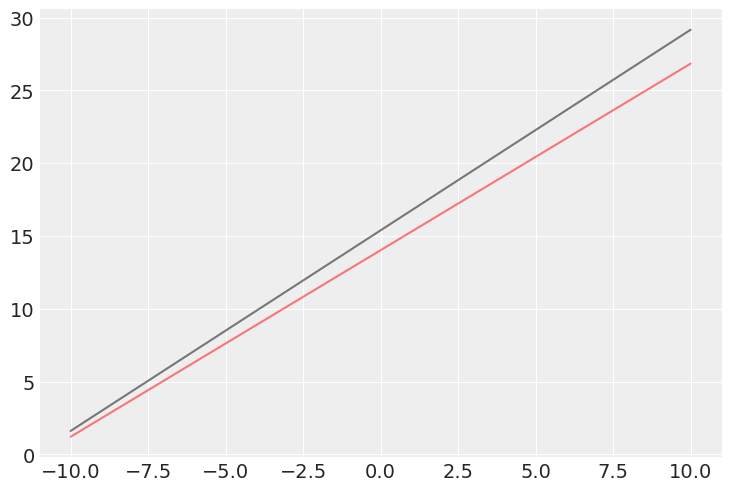

In [ ]:
#difference in best fit line for males and females
samples = np.random.randint(0, 4000, 1000)
x = np.linspace(-10, 10, 50)

y = trace_2_4['alpha'][:,0].mean() + trace_2_4['beta_a'][:,0].mean()*x
y2 = trace_2_4['alpha'][:,1].mean() + trace_2_4['beta_a'][:,1].mean()*x

fig, ax = plt.subplots()
ax.plot(x, y, color='black', alpha=0.5)
ax.plot(x, y2,color='red',alpha=0.5)


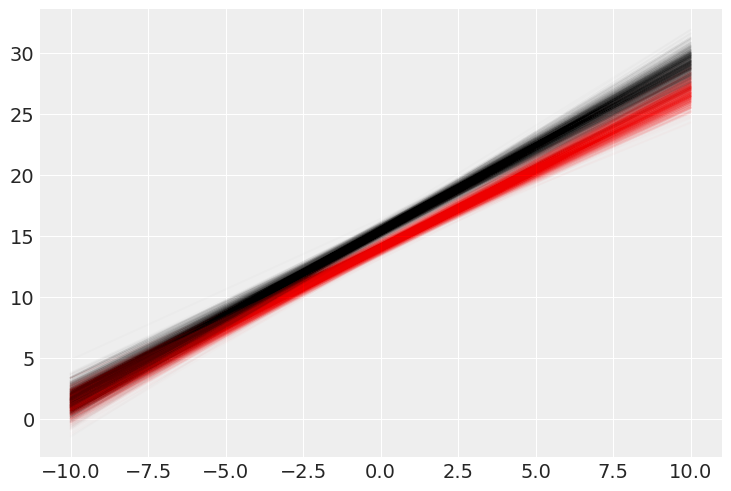

In [121]:
#difference in means for males and females
samples = np.random.randint(0, 4000, 1000)
x = np.linspace(-10, 10, 50)

for i in samples:
    y = trace_2_4['alpha'][:,0][i] + trace_2_4['beta_a'][:,0][i]*x
    plt.plot(
        x,y, alpha=0.01,color='black')
    
    
    y2 = trace_2_4['alpha'][:,1][i] + trace_2_4['beta_a'][:,1][i]*x
    plt.plot(
        x,y2,alpha=0.01,color='red')    

